---


# Object Detection
- dataset : [Small object detection을 위한 이미지 데이터](https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=&topMenu=&aihubDataSe=data&dataSetSn=476)
- model : YOLOv9

---

## 1) Import library

In [2]:
import os
import cv2
import json
import yaml
import math
import random
import shutil
import time
import warnings
import wandb
import argparse
from pathlib import Path
from copy import deepcopy
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torch.distributed as dist
from torch.optim import lr_scheduler

from models.experimental import attempt_load
from models.yolo import Model
from models.common import DetectMultiBackend
from utils.dataloaders import create_dataloader
from utils.general import (LOGGER, TQDM_BAR_FORMAT, Profile, check_amp, check_dataset, check_img_size,
    colorstr, init_seeds, intersect_dicts, labels_to_class_weights, xywh2xyxy, non_max_suppression, scale_boxes)
from utils.loss_tal import ComputeLoss
from utils.metrics import fitness, ConfusionMatrix, ap_per_class
from utils.plots import Annotator, colors, output_to_target, Colors, plot_images
from utils.torch_utils import (ModelEMA, de_parallel, select_device, smart_DDP, smart_optimizer)
from utils.loggers import Loggers, log_tensorboard_graph
from val import process_batch

os.environ["WANDB_MODE"] = "disabled" 
warnings.filterwarnings("ignore")

wandb: W&B disabled due to login timeout.


### 2) Modify Model Architecture

In [ ]:
# common.py
"""
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)

    def forward(self, x):
        batch, channels, _, _ = x.size()
        y = torch.mean(x, dim=(2, 3))  
        y = torch.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).view(batch, channels, 1, 1)
        return x * y  
    
class SEConv(nn.Module):
    default_act = nn.SiLU()  

    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, d=1, act=True, reduction=16):
        super(SEConv, self).__init__()
        self.conv = nn.Conv2d(c1, c2, k, s, autopad(k, p, d), groups=g, dilation=d, bias=False)
        self.bn = nn.BatchNorm2d(c2)
        self.act = self.default_act if act is True else act if isinstance(act, nn.Module) else nn.Identity()
        self.se = SEBlock(c2, reduction=reduction)  # Add SEBlock

    def forward(self, x):
        x = self.act(self.bn(self.conv(x)))
        return self.se(x)  # Add SEBlock

    def forward_fuse(self, x):
        return self.se(self.act(self.conv(x)))
"""

In [ ]:
# gelan-e.yaml
"""
backbone: [
    [-1, 1, Silence, []],

    # conv down
    [-1, 1, SEConv, [64, 3, 2]], # 1-P1/2

    # conv down
    [-1, 1, SEConv, [128, 3, 2]], # 2-P2/4

    ...

    # conv down fuse
    [0, 1, SEConv, [64, 3, 2]], # 15-P1/2
    [[10, 11, 12, 13, 14, -1], 1, CBFuse, [[0, 0, 0, 0, 0]]], # 16

    # conv down fuse
    [-1, 1, SEConv, [128, 3, 2]], # 17-P2/4
    [[11, 12, 13, 14, -1], 1, CBFuse, [[1, 1, 1, 1]]], # 18
    ...
    
"""

## 3) Prepare custom data and configuration

### load annotation data

In [3]:
json_dir = './dataset/example/json'
json_files = [f for f in os.listdir(json_dir) if f.endswith('.json')]
json_path = os.path.join(json_dir, json_files[0])

with open(json_path, 'r', encoding='utf-8') as file:
    data = json.load(file)

output = {
    "images": data["images"],
    "annotations": [{ "category_id": ann["category_id"], "bbox": ann["bbox"] } for ann in data["annotations"]],
    "categories": data["categories"]
}

print(json.dumps(output, indent=4, ensure_ascii=False))

{
    "images": [
        {
            "id": "1167250_597",
            "width": 2800,
            "height": 2100,
            "file_name": "1167250_597.jpg",
            "license": "",
            "date_created": "2022-01-22 13:27:01.111790"
        }
    ],
    "annotations": [
        {
            "category_id": 223,
            "bbox": [
                1880.9695210781213,
                1236.99559728184,
                179.9271295769188,
                108.62179420957955
            ]
        }
    ],
    "categories": [
        {
            "id": "22b84a7a-3cfe-4cfc-a597-293a6c9e5d42",
            "class_id": 223,
            "class_name": "비행기",
            "superclass_id": 597,
            "superclass_name": "비행객체"
        },
        {
            "id": "a5f38f2a-5f4b-443e-bf3e-3c14fc3b3cad",
            "class_id": 224,
            "class_name": "헬리콥터",
            "superclass_id": 597,
            "superclass_name": "비행객체"
        },
        {
            "id": "6dac6f5

### define function for json to yolo format conversion

In [4]:
def update_image_dimensions(json_path, image_dir):
    with open(json_path, 'r', encoding='utf-8') as file:
        data = json.load(file)

    for image in data['images']:
        if image['width'] == 0 or image['height'] == 0:
            image_path = os.path.join(image_dir, image['file_name'])
            if os.path.exists(image_path):
                try:
                    with Image.open(image_path) as img:
                        width, height = img.size
                    image['width'] = width
                    image['height'] = height
                    print(f"Updated dimensions for {image['file_name']}: width={width}, height={height}")
                except Exception as e:
                    print(f"Error processing {image['file_name']}: {e}")

    with open(json_path, 'w', encoding='utf-8') as file:
        json.dump(data, file)

In [5]:
def update_labels_yolo(json_dir, image_dir, output_dir, label_mapping):
    json_files = [f for f in os.listdir(json_dir) if f.endswith('.json')]

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for json_file in json_files:
        json_path = os.path.join(json_dir, json_file)
        with open(json_path, 'r', encoding='utf-8') as file:
            data = json.load(file)

        class_file_count = {new_class: 0 for new_class in label_mapping.values()}
        print(f"\nProcessing {json_file}:")

        for image in data['images']:
            image_id = image['id']
            image_width = image['width']
            image_height = image['height']
            image_filename = image['file_name']

            if image_width == 0 or image_height == 0:
                updated = update_image_dimensions(image, image_dir)
                if not updated:
                    print(f"Skipping {image_filename} due to invalid dimensions.")
                    continue 
    
            label_file = os.path.join(output_dir, os.path.splitext(image_filename)[0] + '.txt')
            with open(label_file, 'w') as lf:
                print(f"\nUpdating {os.path.basename(label_file)}:")  
                for annotation in data['annotations']:
                    if annotation['image_id'] == image_id:
                        class_id = annotation['category_id']
                        bbox = annotation['bbox']

                        x_center = (bbox[0] + bbox[2] / 2) / image_width
                        y_center = (bbox[1] + bbox[3] / 2) / image_height
                        width = bbox[2] / image_width
                        height = bbox[3] / image_height

                        if class_id in label_mapping:
                            new_class_id = label_mapping[class_id]
                            class_file_count[new_class_id] += 1
                            line = f"{new_class_id} {x_center} {y_center} {width} {height}"
                            lf.write(line + "\n")
                            print(line)  

        print(f"\nSummary for {json_file}:")
        for class_id, count in class_file_count.items():
            if count > 0:  
                print(f"Class {class_id}: {count} files updated")

        with open(json_path, 'w', encoding='utf-8') as file:
            json.dump(data, file)

### example

In [6]:
image_dir = './dataset/example/image'
output_dir = './dataset/example/labels' 

label_mapping = {223: 0, 224: 1, 225: 2, 226: 3, 227: 4} 

update_labels_yolo(json_dir, image_dir, output_dir, label_mapping)


Processing 1167250_597.json:

Updating 1167250_597.txt:
0 0.7039046735237788 0.6149078544698237 0.06425968913461386 0.05172466390932359

Summary for 1167250_597.json:
Class 0: 1 files updated


### modify yaml for custom dataset

In [7]:
file_path = "./customYolo9.yaml"

with open(file_path, 'r+') as file:
    data = yaml.safe_load(file)
    data.update({'train': './dataset/train', 'val': './dataset/val', 'test': './dataset/test'})
    file.seek(0)
    yaml.dump(data, file)
    file.truncate()

### setting environment

In [8]:
# Training Config
save_dir = Path('./result')  
weights = './weights/gelan-e.pt'
cfg = './models/detect/gelan-e.yaml'
data = file_path

epochs = 50
batch_size = 32
workers = 0
WORLD_SIZE = 2
seed = 0
close_mosaic = 20
multi_scale= True
quad = False

LOCAL_RANK = int(os.getenv('LOCAL_RANK', -1))  
RANK = int(os.getenv('RANK', -1))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Directories
w = save_dir / 'weights'  
w.mkdir(parents=True, exist_ok=True)
last, best = w / 'last.pt', w / 'best.pt'

# Hyperparameters
hyp_path = './data/hyps/hyp.scratch-high.yaml'

with open(hyp_path, 'r') as f:
    hyp = yaml.safe_load(f)

hyp['anchor_t'] = 5.0

# Seed Initialization
init_seeds(seed + 1 + RANK, deterministic=True)

# Set Dataset Paths and Class
data_dict = check_dataset(data)
 
train_path, val_path, test_path = data_dict['train'], data_dict['val'], data_dict['test']
nc = int(data_dict['nc']) 
names = data_dict['names']

## 4) Model Configuration and Training

In [9]:
# Load checkpoint and Model
ckpt = torch.load(weights, map_location='cpu')  
model = Model(cfg or ckpt['model'].yaml, ch=3, nc=nc, anchors=hyp.get('anchors')).to(device)


                 from  n    params  module                                  arguments                     
  0                -1  1         0  models.common.Silence                   []                            
  1                -1  1      2436  models.common.SEConv                    [3, 64, 3, 2]                 
  2                -1  1     76168  models.common.SEConv                    [64, 128, 3, 2]               
  3                -1  1    252160  models.common.RepNCSPELAN4              [128, 256, 128, 64, 2]        
  4                -1  1    164352  models.common.ADown                     [256, 256]                    
  5                -1  1   1004032  models.common.RepNCSPELAN4              [256, 512, 256, 128, 2]       
  6                -1  1    656384  models.common.ADown                     [512, 512]                    
  7                -1  1   4006912  models.common.RepNCSPELAN4              [512, 1024, 512, 256, 2]      
  8                -1  1   2623488  

In [10]:
# Load state dict
exclude = ['anchor'] if (cfg or hyp.get('anchors')) else []
csd = ckpt['model'].float().state_dict()  
csd = intersect_dicts(csd, model.state_dict(), exclude=exclude)  

model.load_state_dict(csd, strict=False) 
print(f'Transferred {len(csd)}/{len(model.state_dict())} items from {weights}')

# Check amp
amp = check_amp(model)

# Image size
imgsz = 320
gs = max(int(model.stride.max()), 32)  
imgsz = check_img_size(imgsz, gs, floor=gs * 2) 

# Optimizer
nbs = 64 
accumulate = max(round(nbs / batch_size), 1) 
hyp['weight_decay'] *= batch_size * accumulate / nbs 
optimizer = smart_optimizer(model, 'SGD', hyp['lr0'], hyp['momentum'], hyp['weight_decay'])

# Scheduler
lf = lambda x: (1 - x / epochs) * (1.0 - hyp['lrf']) + hyp['lrf'] 
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)
ema = ModelEMA(model)

# Resume
best_fitness, start_epoch = 0.0, 0
resume=False
del ckpt, csd

# DP mode
cuda = device.type != 'cpu'
if cuda and RANK == -1 and torch.cuda.device_count() > 1:
    LOGGER.warning('WARNING ⚠️ DP not recommended, use torch.distributed.run for best DDP Multi-GPU results.')
    model = torch.nn.DataParallel(model)

AMP: checks passed ✅
optimizer: SGD(lr=0.01) with parameter groups 298 weight(decay=0.0), 318 weight(decay=0.0005), 317 bias


Transferred 1805/1827 items from ./weights/gelan-e.pt


WARNING ⚠️ DP not recommended, use torch.distributed.run for best DDP Multi-GPU results.


### load data and configure model

In [11]:
# Train DataLoader
train_loader, dataset = create_dataloader(train_path, imgsz, batch_size // WORLD_SIZE, gs, single_cls=False, hyp=hyp, augment=True, cache=None if 'ram' == 'val' else 'ram', rect=True, rank=LOCAL_RANK, workers=workers,
                                          image_weights=False, close_mosaic=20 != 0, quad=False, prefix=colorstr('train: '), shuffle=True, min_items=0)


# Validation DataLoader
noval = False
val_loader = create_dataloader(val_path, imgsz, batch_size // WORLD_SIZE * 2, gs, single_cls=False, hyp=hyp, cache=None if noval else 'ram', rect=True, rank=-1,
                               workers=workers * 2, pad=0.5,  prefix=colorstr('val: '))[0]

# Label Check
labels = np.concatenate(dataset.labels, 0)
mlc = int(labels[:, 0].max())  # max label class
assert mlc < nc, f'Label class {mlc} exceeds nc={nc} in {data}. Possible class labels are 0-{nc - 1}'

if not resume:
    model.half().float()

# DDP mode
if cuda and RANK != -1:
    model = smart_DDP(model)

# Model attributes
nl = de_parallel(model).model[-1].nl  
hyp['label_smoothing'] = 0.0
model.nc = nc  
model.hyp = hyp  
model.class_weights = labels_to_class_weights(dataset.labels, nc).to(device) * nc 
model.names = names

WARNING ⚠️ --rect is incompatible with DataLoader shuffle, setting shuffle=False
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
train: Scanning /kaggle/working/object-detection-dataset/dataset/train/labels.cache... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 00:00
train: Caching images (0.1GB ram): 100%|██████████| 500/500 00:12
val: Scanning /kaggle/working/object-detection-dataset/dataset/val/labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 00:00
val: Caching images (0.0GB ram): 100%|██████████| 100/100 00:03


### modify annotator and loggers for plot

In [12]:
class CustomAnnotator(Annotator):
    def box_label(self, box, label='', color=(128, 128, 128), txt_color=(255, 255, 255)):
        if self.pil:
            self.draw.rectangle(box, width=self.lw, outline=color) 
            if label:
                #w, h = self.font.getsize(label)  # text width, height
                bbox = self.font.getbbox(label)  # getbbox로 변경
                w, h = bbox[2] - bbox[0], bbox[3] - bbox[1]
                outside = box[1] - h >= 0  
                self.draw.rectangle(
                    (box[0], box[1] - h if outside else box[1], box[0] + w + 1,
                     box[1] + 1 if outside else box[1] + h + 1),
                    fill=color,
                )
                self.draw.text((box[0], box[1] - h if outside else box[1]), label, fill=txt_color, font=self.font)
        else:  
            p1, p2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
            cv2.rectangle(self.im, p1, p2, color, thickness=self.lw, lineType=cv2.LINE_AA)
            if label:
                tf = max(self.lw - 1, 1)  
                w, h = cv2.getTextSize(label, 0, fontScale=self.lw / 3, thickness=tf)[0] 
                outside = p1[1] - h >= 3
                p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
                cv2.rectangle(self.im, p1, p2, color, -1, cv2.LINE_AA)  # filled
                cv2.putText(self.im,
                            label, (p1[0], p1[1] - 2 if outside else p1[1] + h + 2),
                            0,
                            self.lw / 3,
                            txt_color,
                            thickness=tf,
                            lineType=cv2.LINE_AA)

In [13]:
def custom_plot_images(images, targets, paths=None, fname='images.jpg', names=None, show_plot=True):
    if isinstance(images, torch.Tensor):
        images = images.cpu().float().numpy()
    if isinstance(targets, torch.Tensor):
        targets = targets.cpu().numpy()

    max_size = 1920 
    max_subplots = 16 
    bs, _, h, w = images.shape  
    bs = min(bs, max_subplots) 
    ns = np.ceil(bs ** 0.5)  
    if np.max(images[0]) <= 1:
        images *= 255  

    mosaic = np.full((int(ns * h), int(ns * w), 3), 255, dtype=np.uint8) 
    for i, im in enumerate(images):
        if i == max_subplots: 
            break
        x, y = int(w * (i // ns)), int(h * (i % ns)) 
        im = im.transpose(1, 2, 0)
        mosaic[y:y + h, x:x + w, :] = im

    scale = max_size / ns / max(h, w)
    if scale < 1:
        h = math.ceil(scale * h)
        w = math.ceil(scale * w)
        mosaic = cv2.resize(mosaic, tuple(int(x * ns) for x in (w, h)))

    # Annotate
    fs = int((h + w) * ns * 0.01)  
    # CustomAnnotator 
    annotator = CustomAnnotator(mosaic, line_width=round(fs / 10), font_size=fs, pil=True, example=names)
    for i in range(i + 1):
        x, y = int(w * (i // ns)), int(h * (i % ns))  
        annotator.rectangle([x, y, x + w, y + h], None, (255, 255, 255), width=2)  
        if paths:
            annotator.text((x + 5, y + 5), text=Path(paths[i]).name[:40], txt_color=(220, 220, 220)) 
        if len(targets) > 0:
            ti = targets[targets[:, 0] == i] 
            boxes = xywh2xyxy(ti[:, 2:6]).T
            classes = ti[:, 1].astype('int')
            labels = ti.shape[1] == 6  
            conf = None if labels else ti[:, 6] 

            if boxes.shape[1]:
                if boxes.max() <= 1.01:  
                    boxes[[0, 2]] *= w  
                    boxes[[1, 3]] *= h
                elif scale < 1:
                    boxes *= scale
            boxes[[0, 2]] += x
            boxes[[1, 3]] += y
            for j, box in enumerate(boxes.T.tolist()):
                cls = classes[j]
                color = colors(cls)
                cls = names[cls] if names else cls
                if labels or conf[j] > 0.25:  
                    label = f'{cls}' if labels else f'{cls} {conf[j]:.1f}'
                    annotator.box_label(box, label, color=color)
    
    annotator.im.save(fname)

In [14]:
class CustomLoggers(Loggers):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.plot_images = custom_plot_images  

    def on_train_batch_end(self, model, ni, imgs, targets, paths, vals):
        log_dict = dict(zip(self.keys[0:3], vals))
        if self.plots:
            if ni < 3:
                f = self.save_dir / f'train_batch{ni}.jpg'  
                self.plot_images(imgs, targets, paths, f)
                if ni == 0 and self.tb and not self.opt.sync_bn:
                    log_tensorboard_graph(self.tb, model, imgsz=(self.opt.imgsz, self.opt.imgsz))
            if ni == 10 and (self.wandb or self.clearml):
                files = sorted(self.save_dir.glob('train*.jpg'))
                if self.wandb:
                    self.wandb.log({'Mosaics': [wandb.Image(str(f), caption=f.name) for f in files if f.exists()]})
                if self.clearml:
                    self.clearml.log_debug_samples(files, title='Mosaics')

        if self.comet_logger:
            self.comet_logger.on_train_batch_end(log_dict, step=ni)
            
opt = argparse.Namespace(sync_bn=False, resume=False, noplots=False, evolve=False, upload_dataset=False, 
                            data=data, bbox_interval=-1, artifact_alias='latest', epochs=epochs, imgsz=imgsz, 
                            save_period=-1, project='runs/train', entity=None, name='exp')

loggers = CustomLoggers(save_dir=save_dir, weights=weights, opt=opt, hyp=hyp, logger=LOGGER)

ClearML: run 'pip install clearml' to automatically track, visualize and remotely train YOLO 🚀 in ClearML
Comet: run 'pip install comet_ml' to automatically track and visualize YOLO 🚀 runs in Comet
TensorBoard: Start with 'tensorboard --logdir .', view at http://localhost:6006/


### define function for train and validate

In [15]:
def train(model, dataloader, optimizer, scheduler, scaler, compute_loss, device, epoch, epochs, last_opt_step):
    model.train()

    if epoch == (epochs - close_mosaic):
        LOGGER.info("Closing dataloader mosaic")
        dataset.mosaic = False
        
    mloss = torch.zeros(3, device=device) 
    if RANK != -1:
       dataloader.sampler.set_epoch(epoch)
    pbar = enumerate(dataloader)
    accumulate = max(round(nbs / batch_size), 1) 
    LOGGER.info(('\n' + '%11s' * 7) % ('Epoch', 'GPU_mem', 'box_loss', 'cls_loss', 'dfl_loss', 'Instances', 'Size'))
    if RANK in {-1, 0}:    
        pbar = tqdm(pbar, total=nb, bar_format=TQDM_BAR_FORMAT)
    
    optimizer.zero_grad()
    
    for i, (imgs, targets, paths, _) in pbar: 
        ni = i + nb * epoch
        imgs = imgs.to(device, non_blocking=True).float() / 255  

         # Warmup
        if ni <= nw:
            xi = [0, nw]  # x interp
            accumulate = max(1, np.interp(ni, xi, [1, nbs / batch_size]).round())
            for j, x in enumerate(optimizer.param_groups):
                x['lr'] = np.interp(ni, xi, [hyp['warmup_bias_lr'] if j == 0 else 0.0, x['initial_lr'] * lf(epoch)])
                if 'momentum' in x:
                    x['momentum'] = np.interp(ni, xi, [hyp['warmup_momentum'], hyp['momentum']])  

        # Multi-scale
        if multi_scale:
            sz = random.randrange(imgsz * 0.5, imgsz * 1.5 + gs) // gs * gs  
            sf = sz / max(imgs.shape[2:])  
            if sf != 1:
                ns = [math.ceil(x * sf / gs) * gs for x in imgs.shape[2:]]  
                imgs = nn.functional.interpolate(imgs, size=ns, mode='bilinear', align_corners=False)
                
        # Forward
        with torch.cuda.amp.autocast(amp):
            pred = model(imgs) 
            loss, loss_items = compute_loss(pred, targets.to(device)) 
            if RANK != -1:
                loss *= WORLD_SIZE  
            if quad:
                loss *= 4.
                
        # Backward
        scaler.scale(loss).backward()

        if ni - last_opt_step >= accumulate:
            scaler.unscale_(optimizer) 
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)  
            scaler.step(optimizer)  
            scaler.update()
            optimizer.zero_grad()
            if ema:
                ema.update(model)
            last_opt_step = ni
            
        # Log
        if RANK in {-1, 0}:
            mloss = (mloss * i + loss_items) / (i + 1)  # update mean losses
            mem = f'{torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0:.3g}G'  # (GB)
            pbar.set_description(('%11s' * 2 + '%11.4g' * 5) %
                                 (f'{epoch}/{epochs - 1}', mem, *mloss, targets.shape[0], imgs.shape[-1]))
            loggers.on_train_batch_end(model, ni, imgs, targets, paths, list(mloss))

   
    # Scheduler
    lr = [x['lr'] for x in optimizer.param_groups]  
    scheduler.step()
    return mloss, lr

In [16]:
def val(data, batch_size=32, imgsz=imgsz, conf_thres=0.001, iou_thres=0.7, max_det=300, device=0, single_cls=False,  
        project=save_dir / 'runs/val', name='exp', half=True, min_items=0, model=None, dataloader=None,
        save_dir=Path(''), plots=True, verbose=False, compute_loss=None, augment=False):

    # Configure
    model.eval()
    device = torch.device(device) if isinstance(device, str) or isinstance(device, int) else device
    if half and device.type != 'cpu':
        model.half()
    else:
        model.float()
    nc = 1 if single_cls else int(data['nc'])  
    iouv = torch.linspace(0.5, 0.95, 10, device=device)  
    niou = iouv.numel()

    # Dataloader
    seen = 0
    confusion_matrix = ConfusionMatrix(nc=nc)
    names = model.names if hasattr(model, 'names') else model.module.names 
    if isinstance(names, (list, tuple)):  # old format
        names = dict(enumerate(names))
    class_map = list(range(1000))
    s = ('%22s' + '%11s' * 6) % ('Class', 'Images', 'Instances', 'P', 'R', 'mAP50', 'mAP50-95')
    tp, fp, p, r, f1, mp, mr, map50, ap50, map = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
    dt = Profile(), Profile(), Profile()  
    loss = torch.zeros(3, device=device)
    stats, ap, ap_class = [], [], []

    pbar = tqdm(dataloader, desc=s, bar_format=TQDM_BAR_FORMAT) 
    for batch_i, (im, targets, paths, shapes) in enumerate(pbar):
        with dt[0]:
            if cuda:
                im = im.to(device, non_blocking=True)
                targets = targets.to(device)
            im = im.half() if half else im.float() 
            im /= 255  # 0 - 255 to 0.0 - 1.0
            nb, _, height, width = im.shape  

        # Inference
        with dt[1]:
            preds, train_out = model(im) if compute_loss else (model(im, augment=augment), None)

        # Loss
        if compute_loss:
            loss += compute_loss(train_out, targets)[1]  

        # NMS
        targets[:, 2:] *= torch.tensor((width, height, width, height), device=device)  
        lb = []  
        with dt[2]:
            preds = non_max_suppression(preds, conf_thres, iou_thres, labels=lb, multi_label=True, agnostic=single_cls, max_det=max_det)

        # Metrics
        for si, pred in enumerate(preds):
            labels = targets[targets[:, 0] == si, 1:]
            nl, npr = labels.shape[0], pred.shape[0]  
            path, shape = Path(paths[si]), shapes[si][0]
            correct = torch.zeros(npr, niou, dtype=torch.bool, device=device) 
            seen += 1

            if npr == 0:
                if nl:
                    stats.append((correct, *torch.zeros((2, 0), device=device), labels[:, 0]))
                    if plots:
                        confusion_matrix.process_batch(detections=None, labels=labels[:, 0])
                continue

            # Predictions
            if single_cls:
                pred[:, 5] = 0
            predn = pred.clone()
            scale_boxes(im[si].shape[1:], predn[:, :4], shape, shapes[si][1]) 

            # Evaluate
            if nl:
                tbox = xywh2xyxy(labels[:, 1:5])  
                scale_boxes(im[si].shape[1:], tbox, shape, shapes[si][1])  
                labelsn = torch.cat((labels[:, 0:1], tbox), 1) 
                correct = process_batch(predn, labelsn, iouv)
                if plots:
                    confusion_matrix.process_batch(predn, labelsn)
            stats.append((correct, pred[:, 4], pred[:, 5], labels[:, 0])) 

        # Plot images
        if plots and batch_i < 3:
            custom_plot_images(im, targets, paths, save_dir / f'val_batch{batch_i}_labels.jpg', names)  
            custom_plot_images(im, output_to_target(preds), paths, save_dir / f'val_batch{batch_i}_pred.jpg', names)  

        loggers.on_val_batch_end(batch_i, im, targets, paths, shapes, preds)

    # Compute metrics
    stats = [torch.cat(x, 0).cpu().numpy() for x in zip(*stats)]  
    if len(stats) and stats[0].any():
        tp, fp, p, r, f1, ap, ap_class = ap_per_class(*stats, plot=plots, save_dir=save_dir, names=names)
        ap50, ap = ap[:, 0], ap.mean(1)  
        mp, mr, map50, map = p.mean(), r.mean(), ap50.mean(), ap.mean()
    nt = np.bincount(stats[3].astype(int), minlength=nc)  

    # Print results
    pf = '%22s' + '%11i' * 2 + '%11.3g' * 4  
    LOGGER.info(pf % ('all', seen, nt.sum(), mp, mr, map50, map))
    if nt.sum() == 0:
        LOGGER.warning(f'WARNING ⚠️ no labels found in {task} set, can not compute metrics without labels')

    # Print results per class
    training = model is not None
    
    if (verbose or (nc < 50 and not training)) and nc > 1 and len(stats):
        for i, c in enumerate(ap_class):
            LOGGER.info(pf % (names[c], seen, nt[c], p[i], r[i], ap50[i], ap[i]))

    # Print speeds
    t = tuple(x.t / seen * 1E3 for x in dt)  
    if not training:
        shape = (batch_size, 3, imgsz, imgsz)
        LOGGER.info(f'Speed: %.1fms pre-process, %.1fms inference, %.1fms NMS per image at shape {shape}' % t)

    # Plots
    if plots:
        confusion_matrix.plot(save_dir=save_dir, names=list(names.values()))
        loggers.on_val_end(nt, tp, fp, p, r, f1, ap, ap50, ap_class, confusion_matrix)

    # Return results
    model.float()  
    maps = np.zeros(nc) + map
    for i, c in enumerate(ap_class):
        maps[c] = ap[i]
    return (mp, mr, map50, map, *(loss.cpu() / len(dataloader)).tolist()), maps, t

## 5) Train model

In [17]:
# Start training
t0 = time.time()
nb = len(train_loader)
nw = max(round(hyp['warmup_epochs'] * nb), 100) 
best_fitness, start_epoch = 0.0, 0
last_opt_step = -1
maps = np.zeros(nc) 
results = (0, 0, 0, 0, 0, 0, 0)  
scheduler.last_epoch = start_epoch - 1 
scaler = torch.cuda.amp.GradScaler(enabled=amp)
compute_loss = ComputeLoss(model)
save_period = -1

LOGGER.info(f'Image sizes {imgsz} train, {imgsz} val\n'
            f'Using {train_loader.num_workers * WORLD_SIZE} dataloader workers\n'
            f"Logging results to {colorstr('bold', save_dir)}\n"
            f'Starting training for {epochs} epochs...')

Image sizes 320 train, 320 val
Using 0 dataloader workers
Logging results to result
Starting training for 50 epochs...


In [18]:
for epoch in range(start_epoch, epochs):  
    mloss, lr = train(model, train_loader, optimizer, scheduler, scaler, compute_loss, device, epoch, epochs, last_opt_step)
    loggers.on_train_epoch_end(epoch)
    ema.update_attr(model, include=['yaml', 'nc', 'hyp', 'names', 'stride', 'class_weights'])
    final_epoch = (epoch + 1 == epochs)

    results, maps,_ = val(data_dict, batch_size=batch_size // WORLD_SIZE * 2, imgsz=imgsz, half=amp, model=ema.ema, dataloader=val_loader, save_dir=save_dir, plots=False, compute_loss=compute_loss)

    # Update mAP
    fi = fitness(np.array(results).reshape(1, -1)) 
    if fi > best_fitness:
        best_fitness = fi
    log_vals = list(mloss) + list(results) + lr
    loggers.on_fit_epoch_end(log_vals, epoch, best_fitness, fi)

    # Save model
    ckpt = {
        'epoch': epoch,
        'best_fitness': best_fitness,
        'model': deepcopy(de_parallel(model)).half(),
        'ema': deepcopy(ema.ema).half(),
        'updates': ema.updates,
        'optimizer': optimizer.state_dict(),
        'date': datetime.now().isoformat()}

    torch.save(ckpt, last)
    if best_fitness == fi:
        torch.save(ckpt, best)
    if save_period > 0 and epoch % save_period == 0:
        torch.save(ckpt, w / f'epoch{epoch}.pt')
    del ckpt
    loggers.on_model_save(last, epoch, final_epoch, best_fitness, fi)


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       0/49      5.33G      1.843      7.233     0.9082          3        192: 100%|██████████| 32/32 00:39
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 4/4 00:01
                   all        100        137      0.892       0.14      0.207      0.117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       1/49      5.74G       1.92      3.968     0.9201          4        224: 100%|██████████| 32/32 00:23
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 4/4 00:01
                   all        100        137      0.911       0.13      0.189     0.0962

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/49      5.74G      2.243      3.519      1.011          3        320: 100%|██████████| 32/32 00:22
                 Class     

In [19]:
from utils.general import strip_optimizer
LOGGER.info(f'\n{epoch - start_epoch + 1} epochs completed in {(time.time() - t0) / 3600:.3f} hours.')

for f in last, best:
    if f.exists():
        if f is last:
            strip_optimizer(f, last)  
        else:
            strip_optimizer(f, best) 
        if f is best:
            LOGGER.info(f'\nValidating {f}...')
            results, _, _ = val(data_dict, batch_size=batch_size // WORLD_SIZE * 2, imgsz=imgsz, model=attempt_load(f, device).half(), dataloader=val_loader,save_dir=save_dir, verbose=True, plots=True, compute_loss=compute_loss) 


loggers.on_train_end(last, best, epoch, results)
torch.cuda.empty_cache()


50 epochs completed in 0.371 hours.
Optimizer stripped from result/weights/last.pt, saved as result/weights/last.pt, 117.1MB
Optimizer stripped from result/weights/best.pt, saved as result/weights/best.pt, 117.1MB

Validating result/weights/best.pt...
Fusing layers... 
gelan-e summary: 947 layers, 58011831 parameters, 0 gradients
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 4/4 00:01
                   all        100        137      0.403       0.41      0.354      0.183
              airplane        100         21      0.202      0.381      0.168     0.0883
            helicopter        100         21      0.241      0.524      0.383      0.215
           fighter_jet        100         38      0.203      0.211      0.129     0.0491
           paragliding        100         37      0.568      0.324      0.326      0.146
                 drone        100         20      0.802      0.608      0.766      0.416
Results saved to

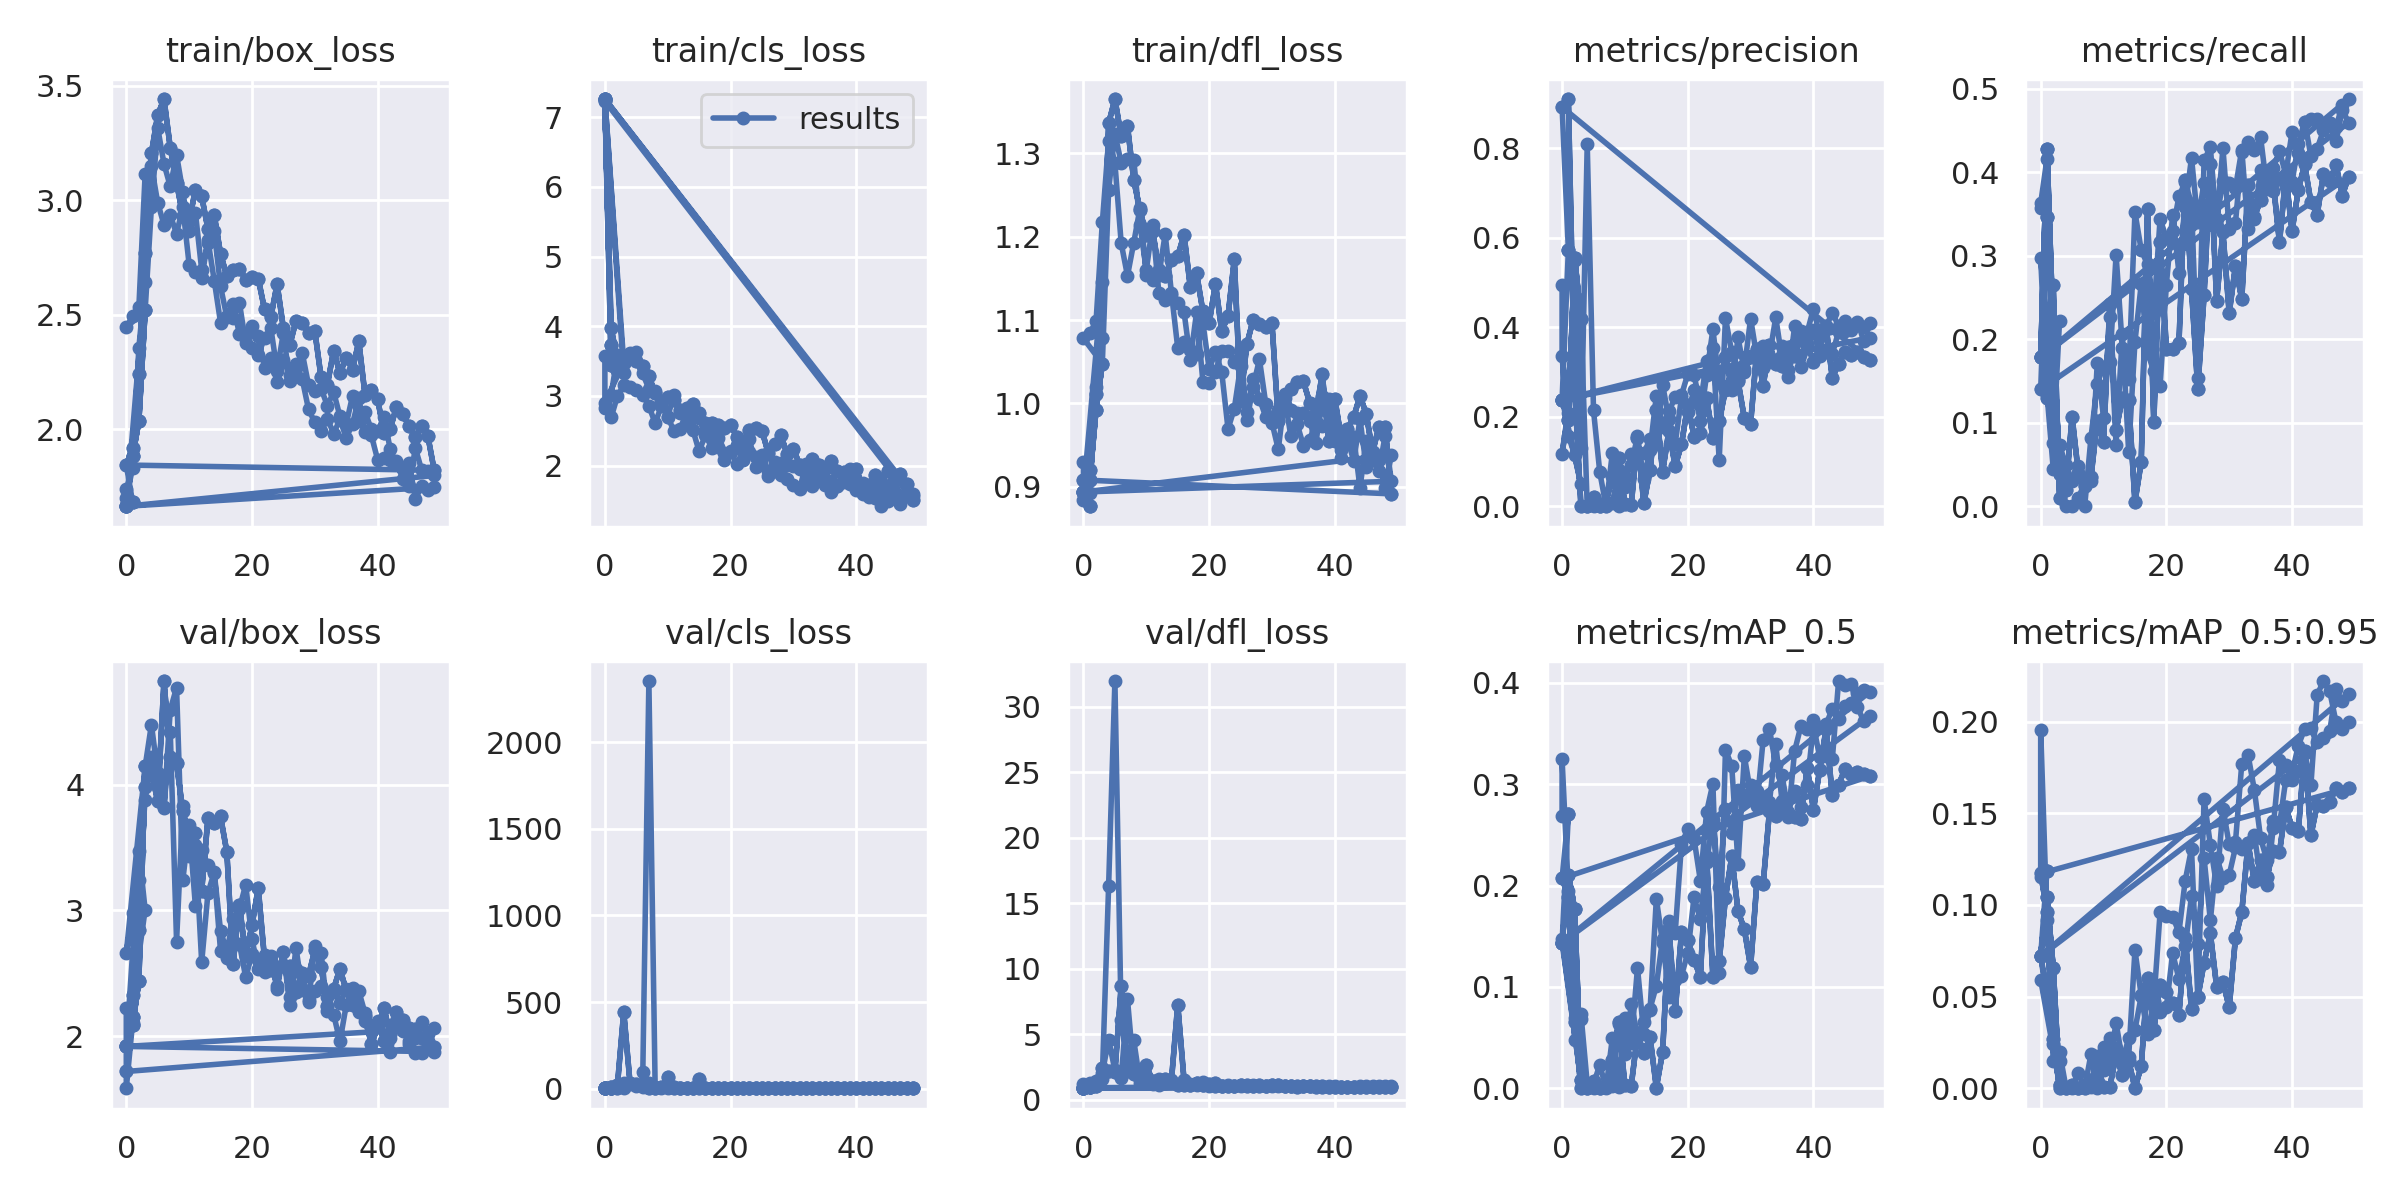

In [20]:
Image.open("./result/results.png")

## 6) Prediction

Fusing layers... 
gelan-e summary: 947 layers, 58011831 parameters, 0 gradients


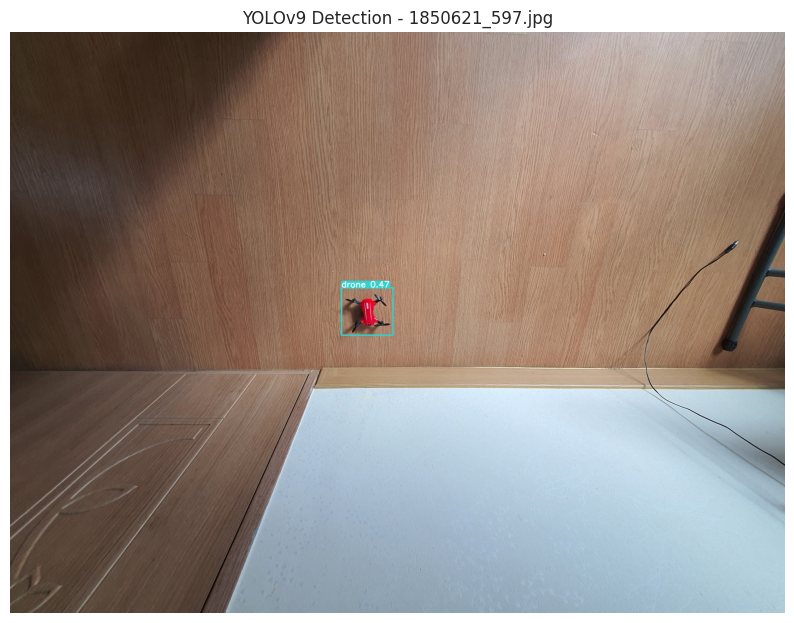

In [21]:
%matplotlib inline
# Constants
image_path = './dataset/test/images/1850621_597.jpg' 
weights = './result/weights/best.pt'
conf_thres = 0.25  
iou_thres = 0.45  
imgsz = (320, 320)

# Load Model
model = DetectMultiBackend(weights, device=device, fp16=False)  

def preprocess_image(image_path, imgsz, device):
    img = cv2.imread(str(image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img0 = img.copy()
    img = cv2.resize(img, imgsz)
    img = img.transpose((2, 0, 1))
    img = np.ascontiguousarray(img)
    img = torch.from_numpy(img).to(device).float() / 255.0
    return img.unsqueeze(0), img0

def visualize_results(img0, pred, model):
    annotator = CustomAnnotator(img0, line_width=3, example=str(model.names))
    for det in pred:
        if len(det):
            det[:, :4] = scale_boxes(img.shape[2:], det[:, :4], img0.shape).round()
            for *xyxy, conf, cls in det:
                label = f'{model.names[int(cls)]} {conf:.2f}'
                annotator.box_label(xyxy, label, color=colors(int(cls), True))
    return annotator.result()

img, img0 = preprocess_image(image_path, imgsz, device)

# Prediction
with torch.no_grad(): 
    pred = model(img)  
    pred = non_max_suppression(pred, conf_thres, iou_thres)  

# Visualization
result_img = visualize_results(img0, pred, model)
result_img = result_img.cpu().numpy() if isinstance(result_img, torch.Tensor) else result_img

# Check dimensions and handle accordingly
if result_img.ndim == 4:
    result_img = result_img.squeeze(0)  # (1, H, W, C) to (H, W, C)

# Display
plt.figure(figsize=(10, 10))
plt.imshow(result_img)  # Ensure result_img is in (H, W, C) format
plt.axis('off')  
plt.title(f'YOLOv9 Detection - {Path(image_path).name}')
plt.show()

## 7) Model Evaluation

In [22]:
def evaluate_model(weights, test_path, data_dict, device='cuda', imgsz=320, batch_size=8, workers=4, save_dir=Path('runs/val'), iou_thres=0.5): 
    device = torch.device(device) if isinstance(device, str) or isinstance(device, int) else device
    model = DetectMultiBackend(weights, device=device, fp16=False) 
    stride, pt, jit, engine = model.stride, model.pt, model.jit, model.engine
    
    test_loader = create_dataloader(test_path,
                                   imgsz,
                                   batch_size,
                                   stride,
                                   single_cls=False,
                                   pad=0.5,
                                   rect=True,
                                   workers=workers,
                                   min_items=0,
                                    prefix=colorstr('test: '))[0]
    
    LOGGER.info(f'\ntesting {weights}...')
    results, _, _ = val(
        data_dict,
        batch_size=batch_size // WORLD_SIZE * 2,
        imgsz=imgsz,
        model=model,
        dataloader=test_loader,
        iou_thres=0.5,
        save_dir=save_dir,
        verbose=True,
        plots=False,
        compute_loss=None
    )
    return results

evaluate_model(
    weights='./result/weights/best.pt',
    test_path=data_dict['test'],
    data_dict=data_dict,
    device='cuda',
    imgsz=320,
    batch_size=8,
    workers=4,
    save_dir=Path('result/val'),
    iou_thres=0.5
)

torch.cuda.empty_cache()


Fusing layers... 
gelan-e summary: 947 layers, 58011831 parameters, 0 gradients
test: Scanning /kaggle/working/object-detection-dataset/dataset/test/labels.cache... 82 images, 0 backgrounds, 0 corrupt: 100%|██████████| 82/82 00:00

testing ./result/weights/best.pt...
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 11/11 00:03
                   all         82         89      0.404      0.337      0.312      0.135
              airplane         82         20       0.27       0.25      0.285      0.108
            helicopter         82         12      0.331      0.583      0.321       0.12
           fighter_jet         82         21      0.248       0.19      0.151     0.0618
           paragliding         82         16      0.205     0.0625     0.0834     0.0354
                 drone         82         20      0.967        0.6      0.722      0.352
